In [2]:
import torch
torch.manual_seed(1746)

B,H,T,S,N,P = 8,16,1000,1000,32,32
Q = torch.randn(B,T,H,N//H).transpose(1,2)
K = torch.randn(B,S,H,N//H).transpose(1,2)
V = torch.randn(B,S,H,P//H).transpose(1,2)
L = torch.tril(torch.ones(T,S)).view(1,1,T,S)

# Standard masked attention
G = Q @ K.transpose(-2,-1)
M = G * L
Y_standard = (M @ V).reshape(B,T,N)

# Single contraction
Y_contraction = torch.einsum('bhtn,bhsn,bhsp,bhts->bhtp', Q, K, V, L).reshape(B,T,N)
print(torch.allclose(Y_standard, Y_contraction, atol=1e-3))

# Step-by-step verification
G_contraction = torch.einsum('bhtn,bhsn->bhts', Q, K)
M_contraction = torch.einsum('bhts,bhts->bhts', G_contraction, L)
Y_step_contraction = torch.einsum('bhts,bhsp->bhtp', M_contraction, V).reshape(B,T,N)
print(torch.allclose(Y_standard, Y_step_contraction, atol=1e-3))

# Derivation for cumsum proof
Z = torch.einsum('bhsp,bhsn->bhspn', V, K)
H = torch.einsum('bhts,bhspn->bhtpn', L, Z)
Y_derivation = torch.einsum('bhtn,bhtpn->bhtp', Q, H).reshape(B,T,N)
print(torch.allclose(Y_standard, Y_derivation, atol=1e-3))

# Cumulative sum formulation
H_cumsum = torch.cumsum(Z, dim=2)
Y_cumsum = torch.einsum('bhtn,bhtpn->bhtp', Q, H_cumsum).reshape(B,T,N)
print(torch.allclose(Y_standard, Y_cumsum, atol=1e-3))

True
True
True
True


In [3]:
B,H,T,S,N,P = 8,16,1000,1000,32,32
Q = torch.randn(B,T,H,N//H, device='cuda').transpose(1,2)
K = torch.randn(B,S,H,N//H, device='cuda').transpose(1,2)
V = torch.randn(B,S,H,P//H, device='cuda').transpose(1,2)
L = torch.tril(torch.ones(T,S, device='cuda')).view(1,1,T,S)

# Standard O(T²) form
Y_standard = ((Q @ K.transpose(-2,-1)) * L) @ V

# Linear form following the blog post
Z = torch.einsum('bhsp,bhsn->bhspn', V, K)  # combine along S
Z_cumsum = torch.cumsum(Z, dim=2)           # cumulative sum over S to apply L implicitly
Y_linear = torch.einsum('bhtn,bhtpn->bhtp', Q, Z_cumsum)

Y_standard = Y_standard.reshape(B,T,N)
Y_linear = Y_linear.reshape(B,T,N)

print(torch.allclose(Y_standard, Y_linear, atol=1e-3))


True


Max absolute difference at T=256: 0.05966949462890625


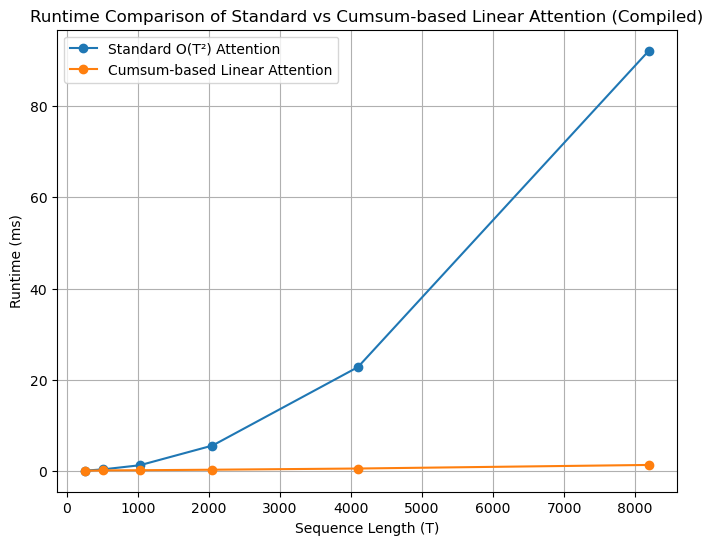

: 

In [4]:
import torch
import time
import matplotlib.pyplot as plt

torch.manual_seed(1746)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.set_float32_matmul_precision('high')

# standard O(T²) attention
def standard_attn(Q, K, V, L):
    return (Q @ K.transpose(-2, -1) * L) @ V

# linear attention using cumulative sums (L incorporated implicitly)
def linear_attn(Q, K, V, _L):
    Z = torch.einsum('bhsp,bhsn->bhspn', V, K)
    # Z_cumsum = torch.cumsum(Z, dim=2)
    Z_cumsum = torch.einsum('bhts,bhspn->bhtpn', _L, Z)
    Y = torch.einsum('bhtn,bhtpn->bhtp', Q, Z_cumsum)
    return Y

compiled_standard_attn = torch.compile(standard_attn)
compiled_linear_attn = torch.compile(linear_attn)

def measure_runtime(T_vals, B=8, H=16, S_factor=1, N=32, P=32, repeats=10):
    standard_times = []
    linear_times = []
    
    # test equivalence at one of the tested lengths
    test_T = T_vals[0]
    S = S_factor * test_T
    Q_test = torch.randn(B,test_T,H,N//H, device=device).transpose(1,2)
    K_test = torch.randn(B,S,H,N//H, device=device).transpose(1,2)
    V_test = torch.randn(B,S,H,P//H, device=device).transpose(1,2)
    L_test = torch.tril(torch.ones(test_T,S, device=device)).view(1,1,test_T,S)

    standard_out = compiled_standard_attn(Q_test, K_test, V_test, L_test)
    linear_out = compiled_linear_attn(Q_test, K_test, V_test, L_test)
    diff = torch.abs(standard_out - linear_out).max().item()
    print(f"Max absolute difference at T={test_T}: {diff}")

    for T in T_vals:
        S = S_factor * T
        Q = torch.randn(B,T,H,N//H, device=device).transpose(1,2)
        K = torch.randn(B,S,H,N//H, device=device).transpose(1,2)
        V = torch.randn(B,S,H,P//H, device=device).transpose(1,2)
        L = torch.tril(torch.ones(T,S, device=device)).view(1,1,T,S)

        # warmup: standard
        for _ in range(3):
            _ = compiled_standard_attn(Q, K, V, L)
            torch.cuda.synchronize() if device == 'cuda' else None

        # measure standard attention
        start = time.time()
        for _ in range(repeats):
            _ = compiled_standard_attn(Q, K, V, L)
            torch.cuda.synchronize() if device == 'cuda' else None
        end = time.time()
        avg_standard = (end - start) / repeats * 1000

        # warmup: linear (cumsum-based)
        for _ in range(3):
            _ = compiled_linear_attn(Q, K, V, L)
            torch.cuda.synchronize() if device == 'cuda' else None

        # measure linear attention
        start = time.time()
        for _ in range(repeats):
            _ = compiled_linear_attn(Q, K, V, L)
            torch.cuda.synchronize() if device == 'cuda' else None
        end = time.time()
        avg_linear = (end - start) / repeats * 1000

        standard_times.append(avg_standard)
        linear_times.append(avg_linear)

    return standard_times, linear_times

# Sequence lengths to test
T_vals = [256, 512, 1024, 2048, 4096, 8192]
standard_times, linear_times = measure_runtime(T_vals, repeats=5)

plt.figure(figsize=(8,6))
plt.plot(T_vals, standard_times, label='Standard O(T²) Attention', marker='o')
plt.plot(T_vals, linear_times, label='Cumsum-based Linear Attention', marker='o')
plt.xlabel('Sequence Length (T)')
plt.ylabel('Runtime (ms)')
plt.title('Runtime Comparison of Standard vs Cumsum-based Linear Attention (Compiled)')
plt.legend()
plt.grid(True)
plt.show()


Max absolute difference at T=625: 3.126388037344441e-13


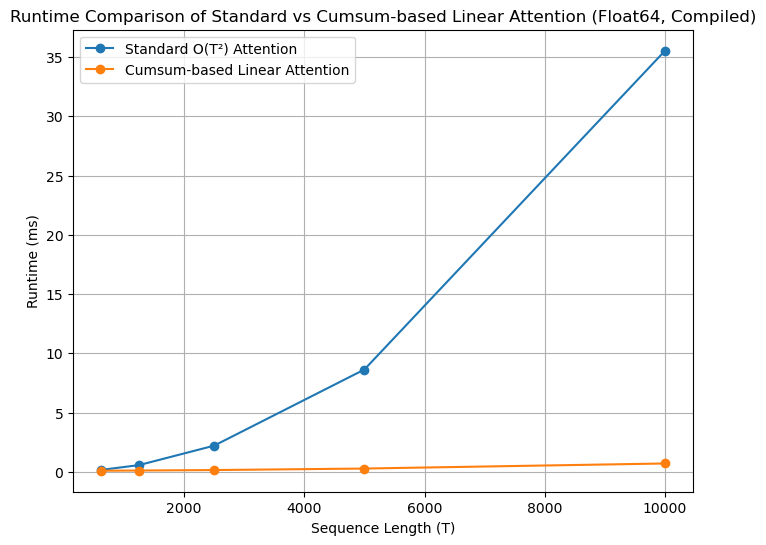

: 

In [4]:
import torch
import time
import matplotlib.pyplot as plt

torch.manual_seed(1746)
torch.set_default_dtype(torch.float64)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# standard O(T²) attention
def standard_attn(Q, K, V, L):
    return (Q @ K.transpose(-2, -1) * L) @ V

# linear attention using cumulative sums (L incorporated implicitly)
def linear_attn(Q, K, V, _L):
    Z = torch.einsum('bhsp,bhsn->bhspn', V, K)
    Z_cumsum = torch.einsum('bhts,bhspn->bhtpn', _L, Z)
    Y = torch.einsum('bhtn,bhtpn->bhtp', Q, Z_cumsum)
    return Y

compiled_standard_attn = torch.compile(standard_attn)
compiled_linear_attn = torch.compile(linear_attn)

def measure_runtime(T_vals, B=1, H=16, S_factor=1, N=32, P=32, repeats=10):
    standard_times = []
    linear_times = []
    
    # test equivalence at one of the tested lengths
    test_T = T_vals[0]
    S = S_factor * test_T
    Q_test = torch.randn(B,test_T,H,N//H, device=device, dtype=torch.float64).transpose(1,2)
    K_test = torch.randn(B,S,H,N//H, device=device, dtype=torch.float64).transpose(1,2)
    V_test = torch.randn(B,S,H,P//H, device=device, dtype=torch.float64).transpose(1,2)
    L_test = torch.tril(torch.ones(test_T,S, device=device, dtype=torch.float64)).view(1,1,test_T,S)

    standard_out = compiled_standard_attn(Q_test, K_test, V_test, L_test)
    linear_out = compiled_linear_attn(Q_test, K_test, V_test, L_test)
    diff = torch.abs(standard_out - linear_out).max().item()
    print(f"Max absolute difference at T={test_T}: {diff}")

    for T in T_vals:
        S = S_factor * T
        Q = torch.randn(B,T,H,N//H, device=device, dtype=torch.float64).transpose(1,2)
        K = torch.randn(B,S,H,N//H, device=device, dtype=torch.float64).transpose(1,2)
        V = torch.randn(B,S,H,P//H, device=device, dtype=torch.float64).transpose(1,2)
        L = torch.tril(torch.ones(T,S, device=device, dtype=torch.float64)).view(1,1,T,S)

        # warmup: standard
        for _ in range(3):
            _ = compiled_standard_attn(Q, K, V, L)
            torch.cuda.synchronize() if device == 'cuda' else None

        # measure standard attention
        start = time.time()
        for _ in range(repeats):
            _ = compiled_standard_attn(Q, K, V, L)
            torch.cuda.synchronize() if device == 'cuda' else None
        end = time.time()
        avg_standard = (end - start) / repeats * 1000

        # warmup: linear (cumsum-based)
        for _ in range(3):
            _ = compiled_linear_attn(Q, K, V, L)
            torch.cuda.synchronize() if device == 'cuda' else None

        # measure linear attention
        start = time.time()
        for _ in range(repeats):
            _ = compiled_linear_attn(Q, K, V, L)
            torch.cuda.synchronize() if device == 'cuda' else None
        end = time.time()
        avg_linear = (end - start) / repeats * 1000

        standard_times.append(avg_standard)
        linear_times.append(avg_linear)

    return standard_times, linear_times

# Sequence lengths to test
T_vals = [625, 1250, 2500, 5000, 10000]
standard_times, linear_times = measure_runtime(T_vals, repeats=5)

plt.figure(figsize=(8,6))
plt.plot(T_vals, standard_times, label='Standard O(T²) Attention', marker='o')
plt.plot(T_vals, linear_times, label='Cumsum-based Linear Attention', marker='o')
plt.xlabel('Sequence Length (T)')
plt.ylabel('Runtime (ms)')
plt.title('Runtime Comparison of Standard vs Cumsum-based Linear Attention (Float64, Compiled)')
plt.legend()
plt.grid(True)
plt.show()


## Chunked Formulation

Sanity check.

Max absolute difference at T=625: 3.126388037344441e-13


/scratch/gpfs/mn4560/.conda/envs/thesis/lib/python3.12/site-packages/torch/_inductor/lowering.py:1532: FutureWarning: `torch._prims_common.check` is deprecated and will be removed in the future. Please use `torch._check*` functions instead.
  check(
/scratch/gpfs/mn4560/.conda/envs/thesis/lib/python3.12/site-packages/torch/_inductor/lowering.py:1532: FutureWarning: `torch._prims_common.check` is deprecated and will be removed in the future. Please use `torch._check*` functions instead.
  check(
/scratch/gpfs/mn4560/.conda/envs/thesis/lib/python3.12/site-packages/torch/_inductor/lowering.py:1532: FutureWarning: `torch._prims_common.check` is deprecated and will be removed in the future. Please use `torch._check*` functions instead.
  check(
/scratch/gpfs/mn4560/.conda/envs/thesis/lib/python3.12/site-packages/torch/_inductor/lowering.py:1532: FutureWarning: `torch._prims_common.check` is deprecated and will be removed in the future. Please use `torch._check*` functions instead.
  check(


ValueError: x and y must have same first dimension, but have shapes (5,) and (4,)

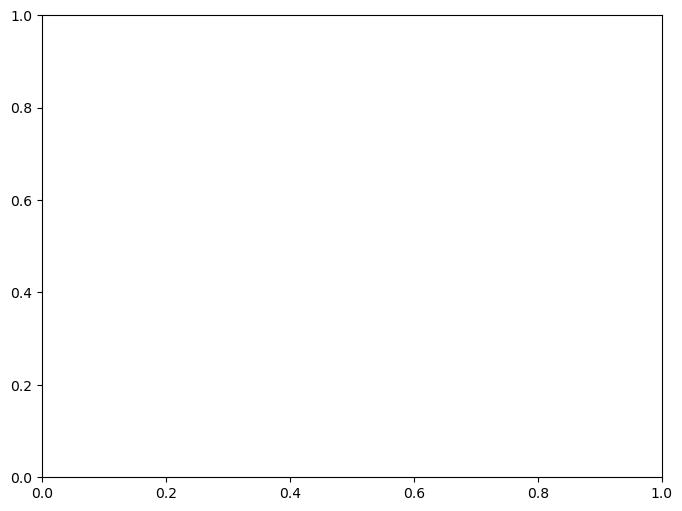

: 

In [1]:
import torch
import time
import matplotlib.pyplot as plt

torch.manual_seed(1746)
torch.set_default_dtype(torch.float64)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# standard O(T²) attention
def standard_attn(Q, K, V, L):
    return (Q @ K.transpose(-2, -1) * L) @ V

# linear attention using cumulative sums (L incorporated implicitly)
def linear_attn(Q, K, V, _L):
    # Q: [B,H,T,D], K: [B,H,S,D], V: [B,H,S,D], _L: [1,1,T,S]
    Z = torch.einsum('bhsp,bhsn->bhspn', V, K)            # [B,H,S,P,N] with P=K.dim(-1), N=V.dim(-1)
    Z_cumsum = torch.einsum('bhts,bhspn->bhtpn', _L, Z)   # cumulative sum style operation
    Y = torch.einsum('bhtn,bhtpn->bhtp', Q, Z_cumsum)     # [B,H,T,P]
    return Y

compiled_standard_attn = torch.compile(standard_attn)
compiled_linear_attn = torch.compile(linear_attn)

def LT_attention_with_initial_state(S_chunk, Q_chunk, K_chunk, V_chunk, L_chunk):
    # Q_chunk, K_chunk, V_chunk shapes: [B,H,c,D]
    # S_chunk: [B,H,D,D] from previous computations
    # L_chunk: [1,1,c,c] lower-triangular mask for local attention

    # Y_state = Q_chunk @ S (cost O(c d^2))
    # We'll treat d as D here
    B,H,c,D = Q_chunk.shape
    # S_chunk: precomputed states [B,H,D,D]
    Y_state = torch.einsum('bhcd,bhdd->bhcd', Q_chunk, S_chunk) # dimension check needed

    # But we must refine S_chunk computations. Let's assume S_chunk stores [B,H,D,D].
    # Actually, from the explanation S_ is built from cumulative sums of P_ = K^T V.
    # For simplicity, let's just pass a precomputed S_chunk and focus on structure.

    # Y_attention = LT_attention_parallel(Q_chunk, K_chunk, V_chunk)
    # We'll just use our linear_attn restricted to this chunk:
    # For local chunked attention, we consider only this chunk window [c,c].
    # We can just use linear_attn on this chunk:
    # L_chunk is like _L but only for the chunk. We'll simulate that by passing L_chunk as _L.
    Y_attention = linear_attn(Q_chunk, K_chunk, V_chunk, L_chunk)

    # Combine
    Y = Y_state + Y_attention
    return Y

def linear_attn_chunked(Q, K, V, L, c):
    # Q,K,V: [B,H,T,D]
    # L: [1,1,T,S]
    # c: chunk size
    B,H,T,D = Q.shape
    S = K.shape[2]
    assert T % c == 0, "T must be divisible by chunk size"
    t_chunks = T // c

    # Reshape Q,K,V into [B,H,(T/c),c,D] for Q and similarly for K,V
    Q_ = Q.reshape(B,H,t_chunks,c,D)
    K_ = K.reshape(B,H,S//c,c,D)
    V_ = V.reshape(B,H,S//c,c,D)

    # from the explanation:
    # P_ = K_.transpose([0,2,1]) @ V_ in original code was simpler
    # Here we must rearrange dimensions to match that logic.
    # We'll do this across the chunk dimension:
    # P_: [B,H,t_chunks,D,D]: each P_ is computed by summing over a chunk dimension of K,V
    # Actually, we must be careful: P_ was computed as K_.T @ V_ per chunk.
    # Let's do P_ chunk by chunk:
    # K_ is [B,H,S/c,c,D], V_ is [B,H,S/c,c,D]
    # We'll consider that S == T for simplicity, so S/c == t_chunks
    # P_[i] = (K_[i].transpose(-2,-1) @ V_[i]) => [B,H,D,D]
    # Then we do a cumsum over i: S_ = cumsum(P_, dim=2) - P_

    P_list = []
    for i in range(t_chunks):
        # K_[i]: [B,H,c,D], V_[i]: [B,H,c,D]
        # we want: P_[i] = (K_[i]^T @ V_[i]), collapsing the chunk dimension c
        # K_[i] transpose last two dims for matmul: [B,H,D,c]
        P_i = torch.einsum('bhcd,bhce->bhde', K_[:, :, i], V_[:, :, i]) # [B,H,D,D]
        P_list.append(P_i)
    P_ = torch.stack(P_list, dim=2)  # [B,H,t_chunks,D,D]

    S_ = torch.cumsum(P_, dim=2) - P_  # [B,H,t_chunks,D,D]

    # Now for each chunk i, we compute:
    # Y_i = LT_attention_with_initial_state(S_[i], Q_[i], K_[i], V_[i])
    # But S_[i] is [B,H,D,D], Q_[i]: [B,H,c,D], K_[i], V_[i]: [B,H,c,D]
    # We also need a chunked L mask: L_chunk is a [1,1,c,c] lower-triangular mask
    Y_list = []
    for i in range(t_chunks):
        Q_i = Q_[:,:,i]  # [B,H,c,D]
        K_i = K_[:,:,i]  # [B,H,c,D]
        V_i = V_[:,:,i]  # [B,H,c,D]
        S_i = S_[:,:,i]  # [B,H,D,D]

        # Construct L_chunk: extract the relevant c x c block from L:
        # L: [1,1,T,S], we want the block corresponding to chunk i.
        # The ith chunk of Q is [i*c:(i+1)*c]
        q_start = i*c
        q_end = (i+1)*c
        L_chunk = L[:,:,q_start:q_end,q_start:q_end]  # [1,1,c,c]

        # Compute Y_i:
        Y_i = LT_attention_with_initial_state(S_i, Q_i, K_i, V_i, L_chunk) # [B,H,c,D]
        Y_list.append(Y_i)

    Y_ = torch.stack(Y_list, dim=2) # [B,H,t_chunks,c,D]
    Y = Y_.reshape(B,H,T,D)
    return Y

compiled_linear_attn_chunked = torch.compile(linear_attn_chunked)

def measure_runtime(T_vals, B=1, H=16, S_factor=1, N=32, P=32, repeats=10, c=250):
    standard_times = []
    linear_times = []
    linear_chunked_times = []
    
    test_T = T_vals[0]
    S = S_factor * test_T
    Q_test = torch.randn(B,test_T,H,N//H, device=device, dtype=torch.float64).transpose(1,2)
    K_test = torch.randn(B,S,H,N//H, device=device, dtype=torch.float64).transpose(1,2)
    V_test = torch.randn(B,S,H,P//H, device=device, dtype=torch.float64).transpose(1,2)
    L_test = torch.tril(torch.ones(test_T,S, device=device, dtype=torch.float64)).view(1,1,test_T,S)

    standard_out = compiled_standard_attn(Q_test, K_test, V_test, L_test)
    linear_out = compiled_linear_attn(Q_test, K_test, V_test, L_test)
    # For chunked, need to ensure T divides by c
    diff = torch.abs(standard_out - linear_out).max().item()
    print(f"Max absolute difference at T={test_T}: {diff}")

    for T in T_vals:
        S = S_factor * T
        if T % c != 0:
            # skip if T not divisible by c
            # or adjust c or handle partial chunk - for simplicity, skip
            continue

        Q = torch.randn(B,T,H,N//H, device=device, dtype=torch.float64).transpose(1,2)
        K = torch.randn(B,S,H,N//H, device=device, dtype=torch.float64).transpose(1,2)
        V = torch.randn(B,S,H,P//H, device=device, dtype=torch.float64).transpose(1,2)
        L = torch.tril(torch.ones(T,S, device=device, dtype=torch.float64)).view(1,1,T,S)

        # warmup: standard
        for _ in range(3):
            _ = compiled_standard_attn(Q, K, V, L)
            torch.cuda.synchronize() if device == 'cuda' else None

        # measure standard attention
        start = time.time()
        for _ in range(repeats):
            _ = compiled_standard_attn(Q, K, V, L)
            torch.cuda.synchronize() if device == 'cuda' else None
        end = time.time()
        avg_standard = (end - start) / repeats * 1000

        # warmup: linear
        for _ in range(3):
            _ = compiled_linear_attn(Q, K, V, L)
            torch.cuda.synchronize() if device == 'cuda' else None

        # measure linear attention
        start = time.time()
        for _ in range(repeats):
            _ = compiled_linear_attn(Q, K, V, L)
            torch.cuda.synchronize() if device == 'cuda' else None
        end = time.time()
        avg_linear = (end - start) / repeats * 1000

        # warmup: linear chunked
        for _ in range(3):
            _ = compiled_linear_attn_chunked(Q, K, V, L, c)
            torch.cuda.synchronize() if device == 'cuda' else None

        # measure chunked linear attention
        start = time.time()
        for _ in range(repeats):
            _ = compiled_linear_attn_chunked(Q, K, V, L, c)
            torch.cuda.synchronize() if device == 'cuda' else None
        end = time.time()
        avg_linear_chunked = (end - start) / repeats * 1000

        standard_times.append(avg_standard)
        linear_times.append(avg_linear)
        linear_chunked_times.append(avg_linear_chunked)

    return standard_times, linear_times, linear_chunked_times

# Example usage:
T_vals = [625, 1250, 2500, 5000, 10000]  # ensure divisibility by c=250 for demonstration
standard_times, linear_times, linear_chunked_times = measure_runtime(T_vals, repeats=5, c=250)

plt.figure(figsize=(8,6))
plt.plot(T_vals, standard_times, label='Standard O(T²) Attention', marker='o')
plt.plot(T_vals, linear_times, label='Cumsum-based Linear Attention', marker='o')
plt.plot(T_vals, linear_chunked_times, label='Chunked Linear Attention', marker='o')
plt.xlabel('Sequence Length (T)')
plt.ylabel('Runtime (ms)')
plt.title('Runtime Comparison of Standard vs Linear vs Chunked Linear Attention (Float64, Compiled)')
plt.legend()
plt.grid(True)
plt.show()
